In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

import scoring as score # para hacer los reportes de puntajes
from time import time

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import RobustScaler  
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

properati = pd.read_csv('datos/caba_para_mapa.csv',error_bad_lines=False)
len (properati)

<IPython.core.display.Javascript object>

48323

In [17]:
properati.info()
properati=properati.loc[properati.price_aprox_usd<1e6]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48323 entries, 0 to 48322
Data columns (total 26 columns):
created_on                    48323 non-null object
property_type                 48323 non-null object
place_name                    48323 non-null object
state_name                    48323 non-null object
lat-lon                       48323 non-null object
lat                           48323 non-null float64
lon                           48323 non-null float64
price                         48323 non-null float64
currency                      48323 non-null object
price_aprox_local_currency    48323 non-null float64
price_aprox_usd               48323 non-null float64
surface_total_in_m2           48323 non-null float64
surface_covered_in_m2         48323 non-null float64
price_usd_per_m2              48323 non-null float64
price_per_m2                  48323 non-null float64
floor                         6223 non-null float64
rooms                         33792 non-null float

In [18]:
properati.loc[:,('created_on')] = pd.to_datetime(properati['created_on'])
properati['anio'] = [x.year for x in properati['created_on'] ]
properati["relacion"] = properati['dist_a_subte']*properati['dist_a_tren']/2

In [19]:
#paso features con strings a numericos
le_barrio = preprocessing.LabelEncoder()
barrios=properati['place_name']
le_barrio.fit(barrios)
properati['place_name'] = le_barrio.transform(barrios)

le_divisa = preprocessing.LabelEncoder()
divisa=properati['currency']
le_divisa.fit(divisa)
properati['currency'] = le_divisa.transform(divisa)

le_tipo = preprocessing.LabelEncoder()
tipos_prop=properati['property_type']
le_tipo.fit(tipos_prop)
properati['property_type'] = le_tipo.transform(tipos_prop)
scaler= RobustScaler()

# RF Clasificador Casas

In [15]:
#preparo set de datos
X = [properati['dist_a_subte'],properati['dist_a_univ'],properati['dist_a_tren'],properati['dist_a_villa'],\
        properati['dist_a_zona_anegada'],properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['lat'],properati['lon']]

y = properati['categories_by_price']

KeyError: 'categories_by_price'

### Busco hiper-parametros con random search

In [ ]:
%%notify

rf = RandomForestClassifier(n_jobs=-1)

oob_score=[True,False]
criterion = ['gini','entropy']
max_features =["auto","log2",None]
n_estimators = np.arange(10,100,10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators,"oob_score":oob_score}

search = RandomizedSearchCV(rf, param_distributions=param_grid ,cv=5,n_iter=5) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

In [ ]:
mejor_rf = search.best_estimator_
print mejor_rf.feature_importances_ # la importancia de cada feature (cuanta informacion le provee al rf) ordenado tal y cual esta zipeado el X

In [ ]:
search.score(X_test,y_test) # pruebo el estimador refiteado con el set de test

# RF Regresor

In [7]:
#preparo set de datos
X = zip(properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['lat'],properati['relacion'])
        #,properati["dist_a_tren"],properati["dist_a_subte"])
y = properati['price_aprox_usd']
X=scaler.fit_transform(X,y)

In [8]:
%%notify

rf = RandomForestRegressor(n_jobs=-1)

criterion = ['mse']
max_features =["auto","log2",None]
n_estimators = np.arange(10,200,10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = RandomizedSearchCV(rf, param_distributions=param_grid ,cv=5,n_iter=50) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

### Hago GS en los mejores

In [10]:
%%notify

rf = RandomForestRegressor(n_jobs=-1)

criterion = ['mse']
max_features =['log2']
n_estimators = np.arange(10,200,10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = GridSearchCV(rf, param_grid=param_grid ,cv=5) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 193.54 segundos para 19 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: 0.980 (std: 0.000)
Promedio validation score: 0.866 (std: 0.005)
Promedio fit time: 2.523s
Hiper-parametros: {'max_features': 'log2', 'n_estimators': 180, 'criterion': 'mse'}

Puesto: 2
Promedio training score: 0.980 (std: 0.000)
Promedio validation score: 0.866 (std: 0.005)
Promedio fit time: 2.655s
Hiper-parametros: {'max_features': 'log2', 'n_estimators': 190, 'criterion': 'mse'}

Puesto: 3
Promedio training score: 0.980 (std: 0.000)
Promedio validation score: 0.866 (std: 0.005)
Promedio fit time: 2.544s
Hiper-parametros: {'max_features': 'log2', 'n_estimators': 170, 'criterion': 'mse'}

Puesto: 4
Promedio training score: 0.980 (std: 0.000)
Promedio validation score: 0.865 (std: 0.005)
Promedio fit time: 2.330s
Hiper-parametros: {'max_features': 'log2', 'n_estimators': 150, 'criterion': 'mse'}

Puesto: 5
Promedio training score: 0.979 (std: 0.000)
Promedio validation score: 0

<IPython.core.display.Javascript object>

In [11]:
mejor_rf = search.best_estimator_
print mejor_rf.feature_importances_ # la importancia de cada feature (cuanta informacion le provee al rf) ordenado tal y cual esta zipeado el X

[ 0.33513637  0.41799474  0.12896171  0.11790718]


In [12]:
search.score(X_test,y_test)

0.87132959997828763

In [13]:
errores = mejor_rf.predict(X_test)-y_test
print ("Error maximo:{0}\nError minimo:{1}".format( max(abs(errores)),min(abs(errores))))
print(errores)

Error maximo:740985.733333
Error minimo:0.0
34296    -23527.777778
41277    -25994.444444
2521      -1366.203704
28205     50672.701389
26250    -11863.518519
15302    -57350.972222
35168      4855.229048
4443      16099.715432
46426    -16662.407407
37386    -57992.036111
3388    -154356.575926
20749     21140.277778
28406     19496.666667
23734     -7149.568519
35899     68138.700000
8530          0.000000
40437        52.849868
22643     21523.476896
19417     -9392.439683
26039      5498.421296
25345    -57688.188889
42725   -122554.444444
10355        -8.333333
42702     23346.296296
22109     14754.294533
48127     50574.050741
45679    -39656.944444
27695      9114.948107
23831    -25470.873016
14227     16262.777778
             ...      
14170     59299.037963
20702   -351932.233333
11572       969.137037
24176      4561.212963
46168    -17173.309259
7053      27616.666667
6199        282.301389
14044     -4414.124074
47188     -1898.843122
41871    -19964.484392
24532      90

## Analsis de errores

In [14]:
count_max=0
max_error=1000
lista=[]
for error in errores:
    if abs(error)>=max_error:
        count_max+=1
        lista.append(abs(error))
print ("Hay {0} de de {1} que tienen mas de {2} USD de error".format(count_max,len(errores),max_error))

Hay 8632 de de 9474 que tienen mas de 1000 USD de error


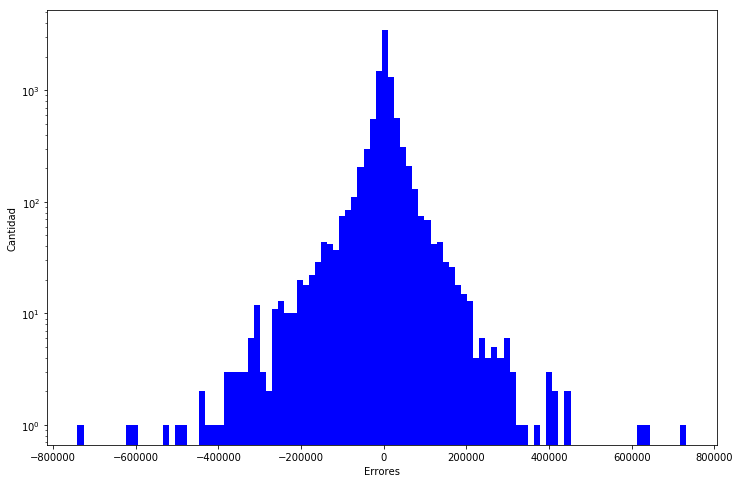

In [15]:
# the histogram of the data
plt.figure(figsize=(12,8))
plt.hist(errores, 100, facecolor='blue')
plt.xlabel('Errores')
plt.ylabel('Cantidad')
#plt.xlim(-1000, 1000) #para variar el "zoom a 0"
plt.yscale('log')
plt.show()

###  Distribucion de precios

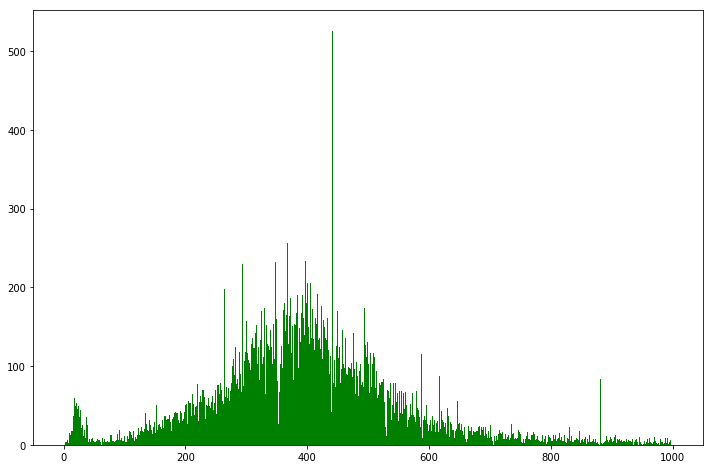

In [89]:
plt.figure(figsize=(12,8))
cant_buckets=1000
cantidad,rango = np.histogram(properati['price_usd_per_m2'], bins=cant_buckets)
properati['categories_by_price']=pd.cut(properati['price_usd_per_m2'],rango,labels=np.arange(cant_buckets),include_lowest=True)
plt.hist(properati.categories_by_price,cant_buckets,facecolor='green')
plt.show()

## Pruebo reduccion con RF

In [5]:
X = zip(properati['dist_a_subte'],properati['dist_a_univ'],properati['dist_a_tren'],properati['dist_a_villa'],\
        properati['dist_a_zona_anegada'],properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['lat'],properati['lon'])

y = properati['price_aprox_usd']

X=scaler.fit_transform(X,y)

In [8]:
%%notify

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

estimators = [('pca', PCA()), ('rf', RandomForestRegressor())]
pipe = Pipeline(estimators)

criterion = ['mse']
max_features =['log2']
n_estimators = np.arange(170,200,10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid= dict( pca__n_components=np.arange(1,8,1),rf__criterion = criterion,
rf__max_features =max_features,
rf__n_estimators = n_estimators)

grid_search = GridSearchCV(pipe, param_grid=param_grid,n_jobs=-1,refit=True,cv=5)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease...timators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'rf__n_estimators': array([170, 180, 190]), 'pca__n_components': array([1, 2, 3, 4, 5, 6, 7]), 'rf__criterion': ['mse'], 'rf__max_features': ['log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

<IPython.core.display.Javascript object>

In [9]:
grid_search.best_estimator_.score(X_test,y_test)

0.88303320656392525

In [10]:
estimador_pipe=grid_search.best_estimator_
estimador_pipe

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0....imators=170, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [11]:
estimador_pipe.get_params
estimador_pipe.steps[1][1].feature_importances_

array([ 0.56243461,  0.09539613,  0.05607901,  0.12204571,  0.06051094,
        0.04868756,  0.05484603])

In [12]:
errores = estimador_pipe.predict(X_test)-y_test

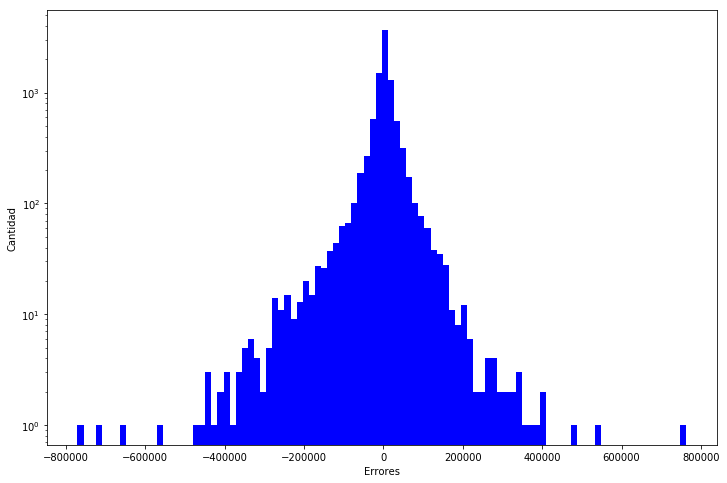

In [13]:
# the histogram of the data
plt.figure(figsize=(12,8))
plt.hist(errores, 100, facecolor='blue')
plt.xlabel('Errores')
plt.ylabel('Cantidad')
#plt.xlim(-1000, 1000) #para variar el "zoom a 0"
plt.yscale('log')
plt.show()